In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import string
import seaborn as sns
from scipy import stats
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

With the data acquisition process complete using Spotify and Lyrics Genius as well as working through data wrangling and pre-processing using Pandas and various NLP techniques, we can now begin to explore the dataset to answer questions and gain insights as to what type of features may potentially influence the genre of a particular song. Moreover, we can use advanced text modeling to discover what are the most common words in each genre and use the unsupervised approach of topic modeling to break down what the various subjects that the lyrics are written about can relate to and find any areas of commonality between songs and within potential subgenres.

In [2]:
#Read in dataframe from Spotify Data Extraction section containing musical attributes
spotify_df = pd.read_csv('spotify_genre_df_cleaned.csv')

The first step taken is to create a new dataframe that is the aggregate of all the songs in a particular genre. This is done by using the Pandas groupby method. In addition we will use the aggregate method to find the average of the numerical metrics across the 2000 songs in each genre. There are a number of statistical metrics we can aggregate the data on including mean, median, and mode. The most commonly used metric would be the mean, which is the statistical average of all the numbers in a set. However, given the high variability of many of the features in our dataset as well as likely outliers, we decided to use median as it is representative of the middle number of the dataset and resistant to outliers.

In [9]:
#Aggregate dataframe by genre and use median as the measure to average numerical data to account for outliers
spotify_df_agg = spotify_df.groupby(['genre'], as_index=False).aggregate('median')
spotify_df_agg

,genre,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
0,Country,0.5715,0.6695,-6.3630,0.0335,0.000001,0.1235,0.519,124.9930,3.531117,211867.0,4.0,274.0,125.0,107.0,65.0,5.0,200.0,1708.0,756.0
1,Electronic/Dance,0.6160,0.8380,-4.8665,0.0594,0.012300,0.1525,0.325,127.9875,3.627825,217669.5,4.0,153.0,69.0,38.0,20.0,0.0,362.0,1747.0,1471.0
2,Hip-Hop,0.7590,0.6230,-6.7195,0.2295,0.000000,0.1350,0.445,121.0750,3.297925,197875.5,4.0,493.0,244.0,175.0,121.0,11.0,220.0,1798.0,752.0
3,Pop,0.6435,0.6240,-6.0205,0.0515,0.000000,0.1180,0.466,118.8915,3.479333,208760.0,4.0,337.0,156.0,102.0,62.0,4.0,437.0,1762.0,1168.0
4,Rock,0.4920,0.7680,-5.8910,0.0412,0.000094,0.1250,0.401,124.0260,3.948950,236937.0,4.0,248.0,115.0,84.0,51.0,2.0,322.0,1793.0,967.0


The aggregated dataframe provides us with a quick overview of the data and presents a few quick insights. One of the things that pops out is that Hip-Hop music on average has a considerably higher word count that any other genres with the next closest being Pop with almost nearly half as high a median word count. This is something we would expect given that the Hip-Hop genre primarily consists of songs that include Rap lyrics which as heavy on word usage.

Another takeaway is that the valence is highest in Country music. Valence, as desribed by the Spotify API website, is a measure of the degree of positivity (sounding more cheerful, happy, euphoric) of a song. It is interesting to see country music having the highest valence value, but not entirely unexpected given the key of most country songs I have heard is major and the themes of the lyrics generally involve positive topics.

Finally, we can see that the highest degree of energy on average is in EDM music, which is understandable given how most of the music involves high levels of bass and drums to create an environment suitable for dancing at clubs. There are several other aspects to explore that we will do by plotting the distribution of each feature so we can go beyond the median and see the variance against each genre.

In [12]:
spotify_df.describe()

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.606127,0.681767,-6.407974,0.100645,0.064241,0.194992,0.451779,123.758013,3.728424,223705.434300,3.947800,292.016400,143.36170,101.580400,66.933000,7.426000,308.200000,1761.600000,1022.80000
std,0.151107,0.193031,2.745441,0.108305,0.190840,0.156917,0.226044,29.042635,1.016910,61014.595684,0.302464,189.120885,101.91238,72.126808,55.220248,11.673352,88.503917,32.856475,271.89401
min,0.061700,0.016700,-26.967000,0.022600,0.000000,0.014100,0.025800,43.509000,0.646000,38760.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,200.000000,1708.000000,752.00000
25%,0.506000,0.551000,-7.762250,0.035300,0.000000,0.097600,0.272000,99.992500,3.124825,187489.500000,4.000000,179.000000,81.00000,60.000000,34.000000,0.000000,220.000000,1747.000000,756.00000
50%,0.605000,0.705000,-5.962500,0.051000,0.000005,0.128000,0.433000,124.988500,3.579083,214745.000000,4.000000,281.000000,130.00000,96.000000,58.000000,3.000000,322.000000,1762.000000,967.00000
75%,0.713000,0.837000,-4.573750,0.111000,0.001480,0.253000,0.617250,143.994500,4.149838,248990.250000,4.000000,392.000000,191.00000,131.000000,85.000000,10.000000,362.000000,1793.000000,1168.00000
max,0.981000,0.999000,0.878000,0.944000,0.989000,0.982000,0.978000,208.951000,15.725483,943529.000000,5.000000,825.000000,766.00000,574.000000,563.000000,153.000000,437.000000,1798.000000,1471.00000


Since our data set includes a combination of continuous numerical variables, categorical variables, and fixed variables, we will first break each of these features into lists so that it is easier to visualize the groups of features individually using plots applicable to the type of data. We will also include a list containing the five genre names so that we can loop through and visualize the data at a genre level.

In [14]:
numerical_variables = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 
                       'valence', 'tempo', 'duration_minutes', 'word_count', 'word_count_cleaned', 'word_count_unique',
                       'word_count_cleaned_unique', 'entity_count_unique']

fixed_variables = ['count_artist', 'count_track', 'count_album']

categorical_variables = ['genre', 'full_key', 'key', 'mode', 'lyrics', 'lyrics_tokenized', 
                         'lyrics_cleaned', 'named_entities']

target_variable = 'genre'

genres = ['Rock', 'Pop', 'Hip-Hop', 'Country', 'Electronic/Dance']

In [39]:
spotify_df[numerical_variables].head(5)

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,count_artist,count_track,count_album
0,0.556,0.913,-2.360,0.0437,0.000009,0.346,0.730,96.184,4.702667,306.0,161.0,144.0,105.0,322.0,1793.0,967.0
1,0.592,0.767,-2.788,0.0270,0.001650,0.127,0.328,96.483,5.495550,286.0,154.0,151.0,98.0,322.0,1793.0,967.0
2,0.433,0.959,-4.040,0.0431,0.000000,0.028,0.365,172.984,4.489550,461.0,174.0,106.0,66.0,322.0,1793.0,967.0
3,0.502,0.912,-4.556,0.0564,0.000173,0.106,0.720,116.761,5.032000,249.0,138.0,85.0,48.0,322.0,1793.0,967.0
4,0.595,0.717,-4.803,0.0295,0.002740,0.108,0.547,88.969,3.598450,248.0,115.0,79.0,49.0,322.0,1793.0,967.0


In [45]:
spotify_df[categorical_variables].head(5)

,playlist_name,full_key,key,mode,lyrics,lyrics_tokenized,lyrics_cleaned,named_entities
0,Rock,C Major,C,Major,gettin' born in the state of mississippi po...,"['gettin', ""'"", 'born', 'in', 'the', 'state', ...","['gettin', 'born', 'state', 'mississippi', 'po...","[mississippi poppa, alabama, sweet louisiana r..."
1,Rock,A Minor,A,Minor,psychic spies from china try to steal your mi...,"['psychic', 'spies', 'from', 'china', 'try', '...","['psychic', 'spy', 'china', 'try', 'steal', 'e...","(china, sweden, east, hollywood, hollywood, al..."
2,Rock,A Major,A,Major,keep you in the dark you know they all preten...,"['keep', 'you', 'in', 'the', 'dark', 'you', 'k...","['keep', 'dark', 'know', 'pretend', 'keep', 'd...",()
3,Rock,C# Major,C#,Major,load up on guns bring your friends it's fun t...,"['load', 'up', 'on', 'guns', 'bring', 'your', ...","['load', 'gun', 'bring', 'friend', 'fun', 'los...",()
4,Rock,C Major,C,Major,scar tissue that i wish you saw sarcastic mis...,"['scar', 'tissue', 'that', 'i', 'wish', 'you',...","['scar', 'tissue', 'wish', 'saw', 'sarcastic',...","(kentucky, fallin, ma, pa, viewin, autumn)"


While we were able to gain some insights into the median values in our Spotify attributes dataset, we still don't quite know the variance of each numerical attribute within all songs in a particular genre. As such, we will attempt to answer this by using a histogram to see the distribution of each variable across all of the songs within each genre by looping through the genres and numerical variables.

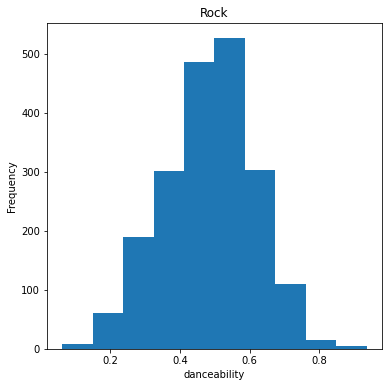

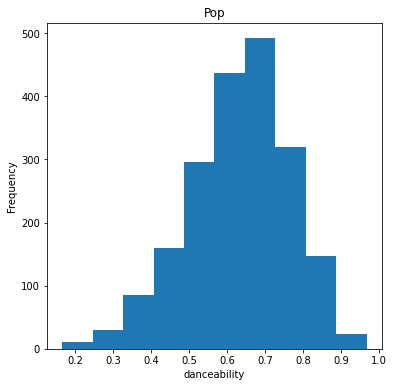

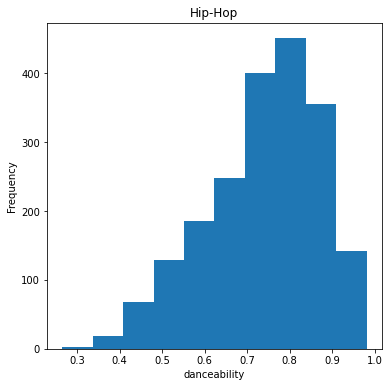

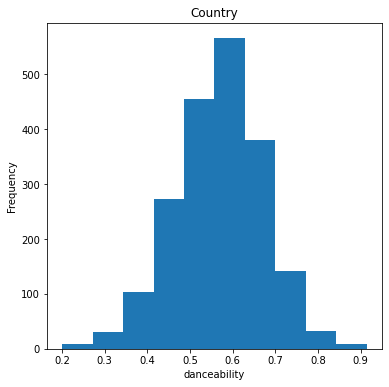

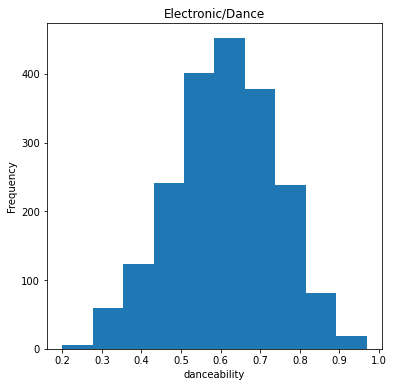

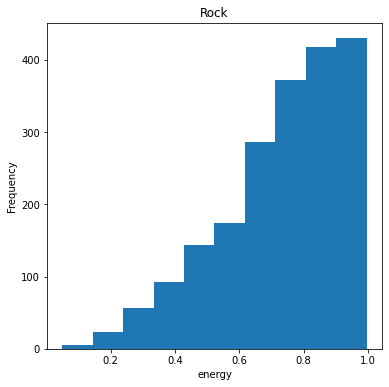

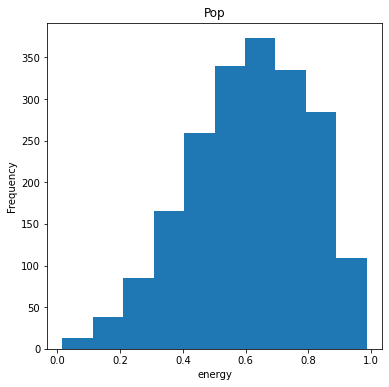

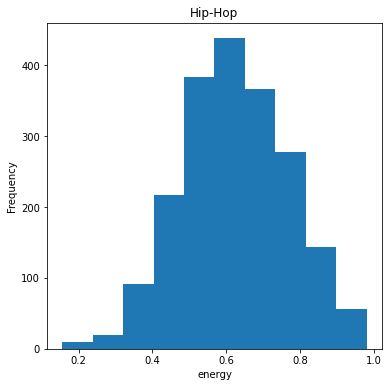

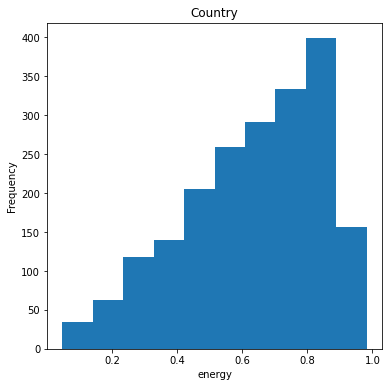

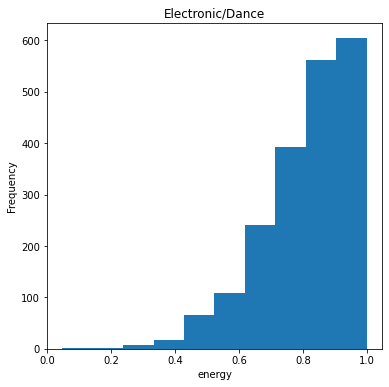

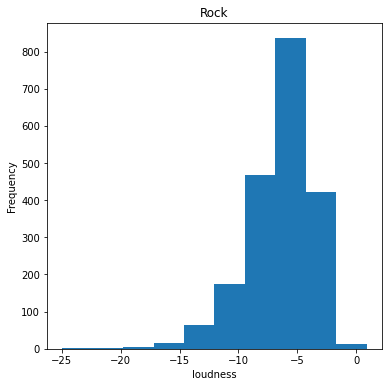

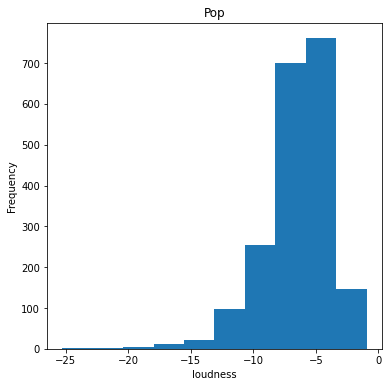

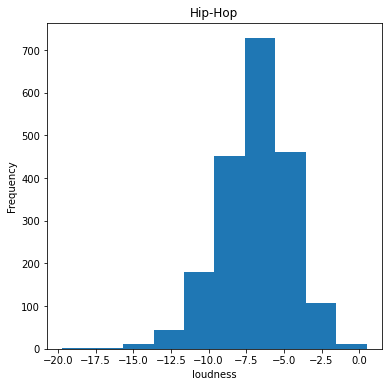

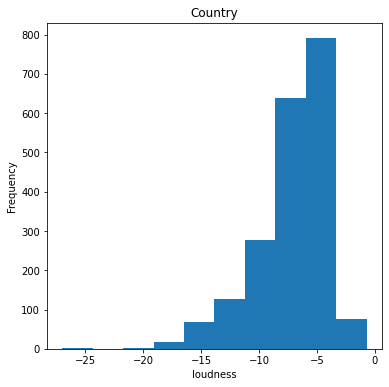

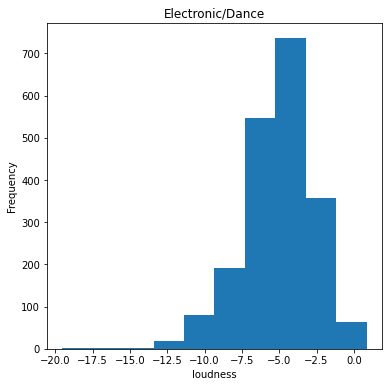

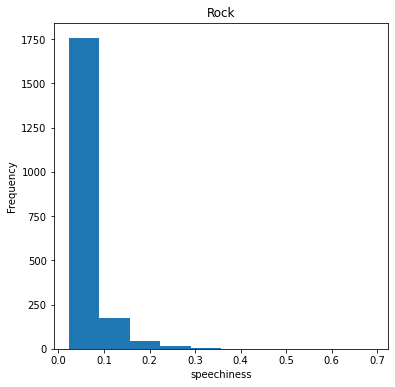

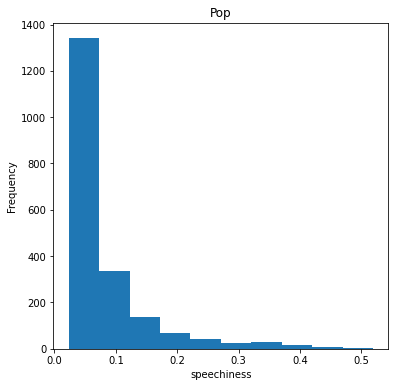

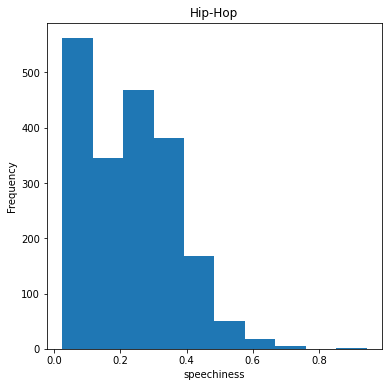

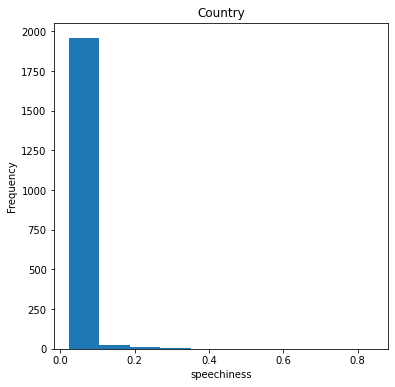

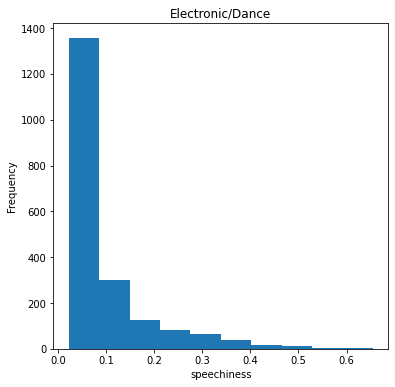

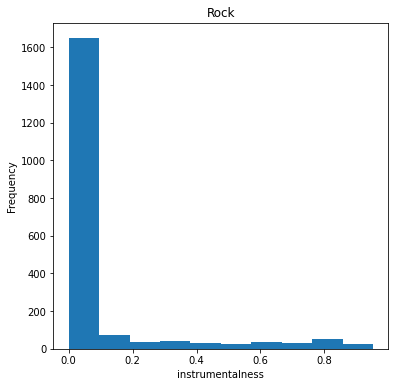

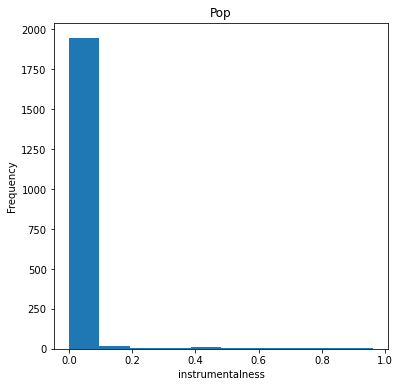

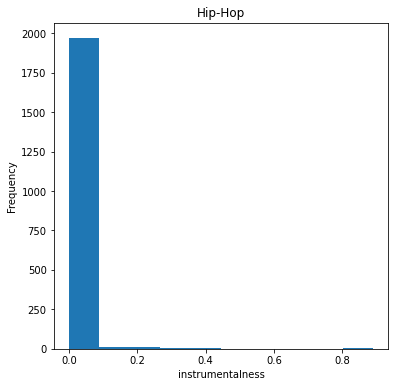

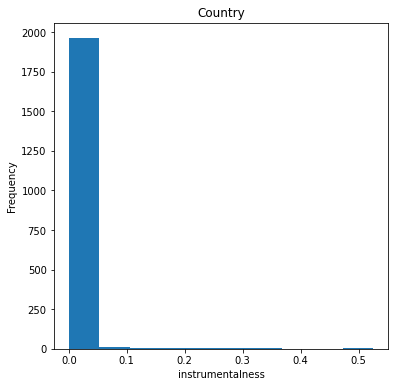

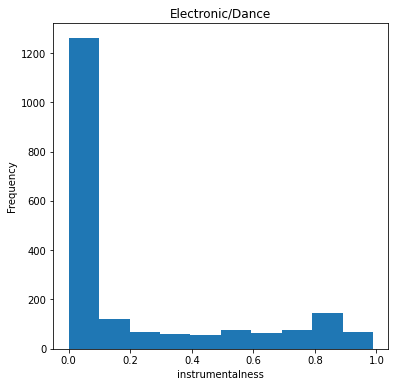

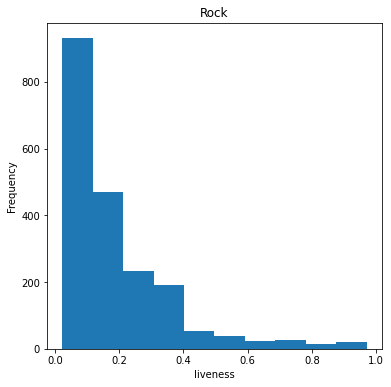

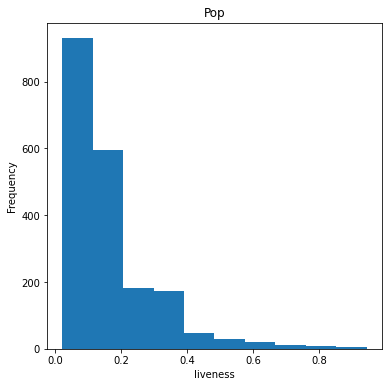

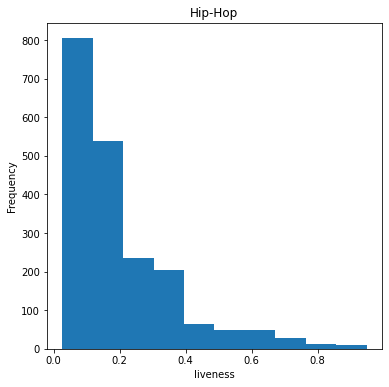

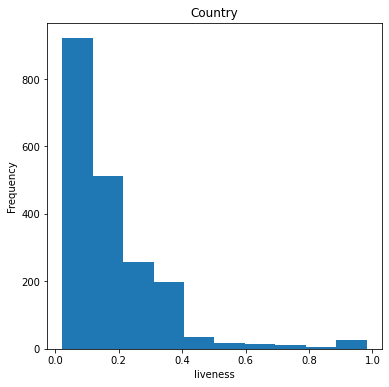

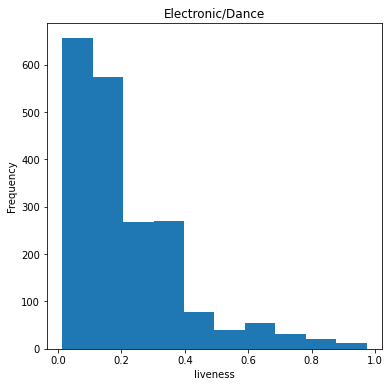

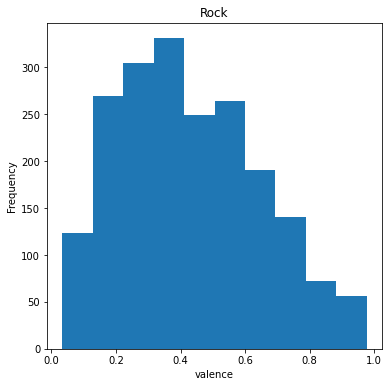

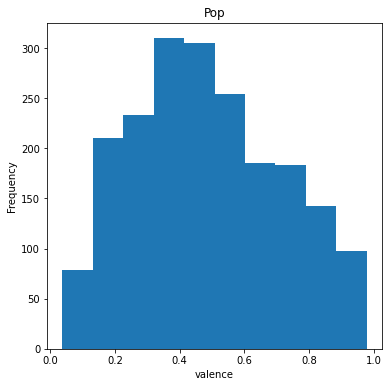

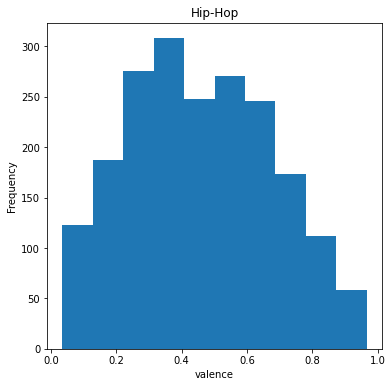

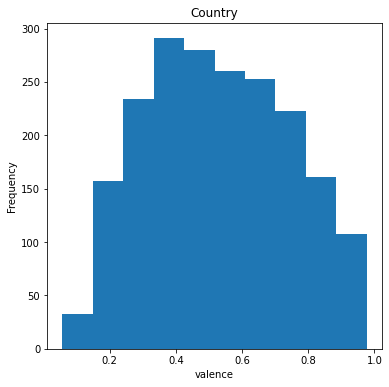

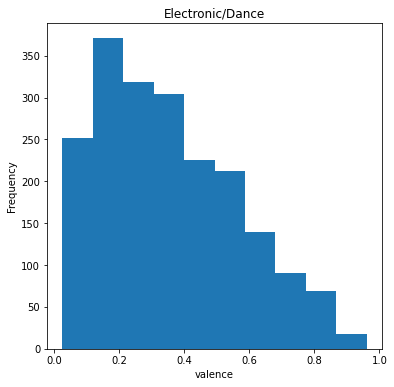

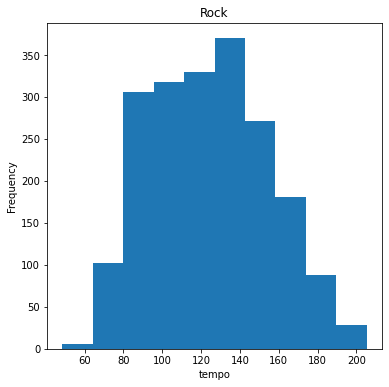

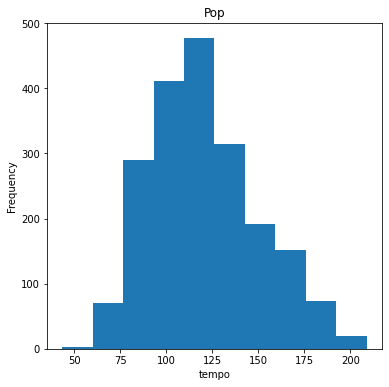

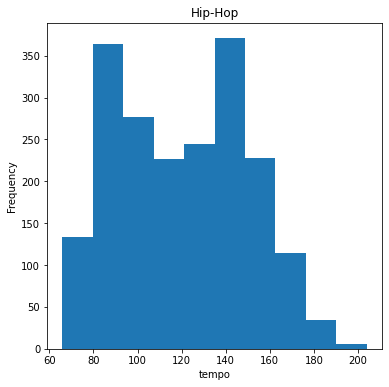

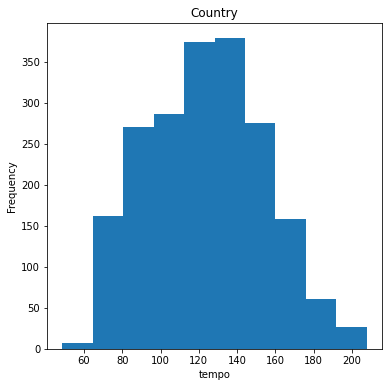

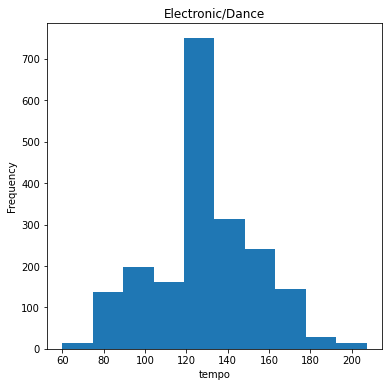

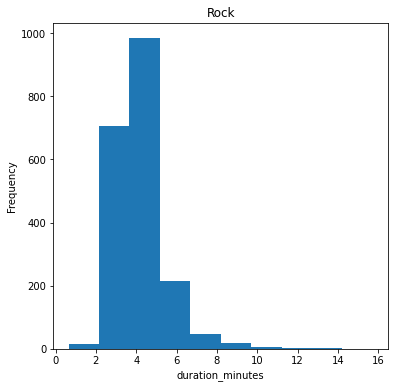

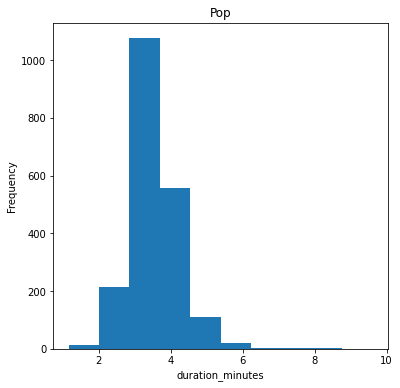

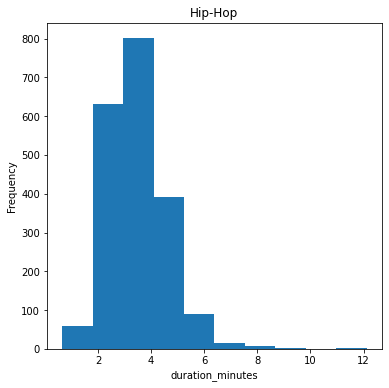

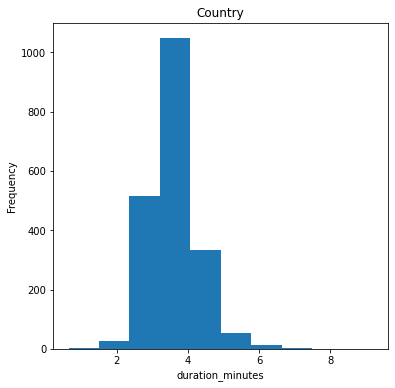

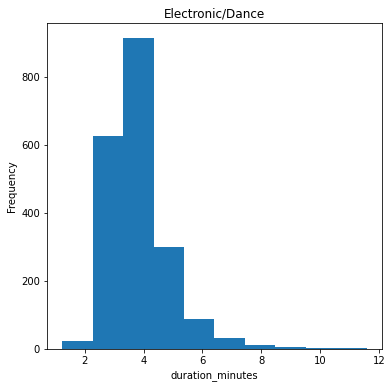

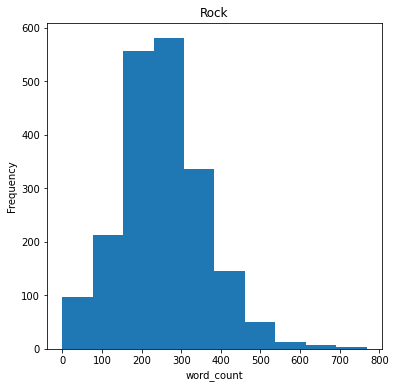

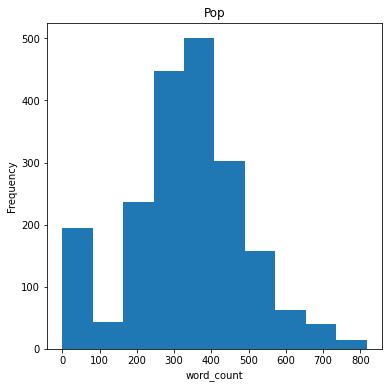

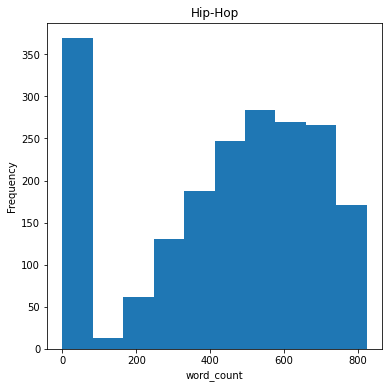

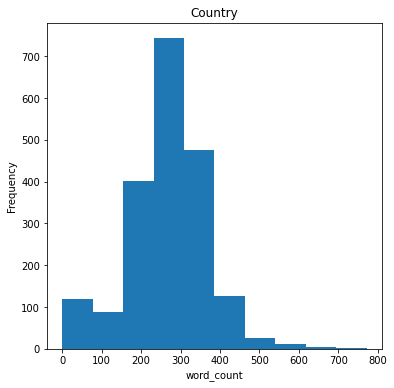

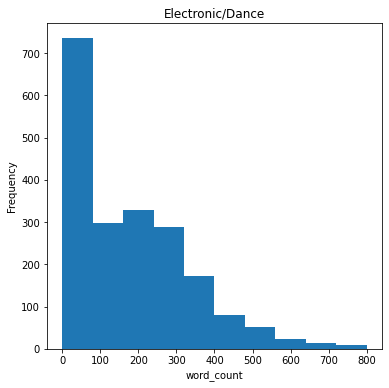

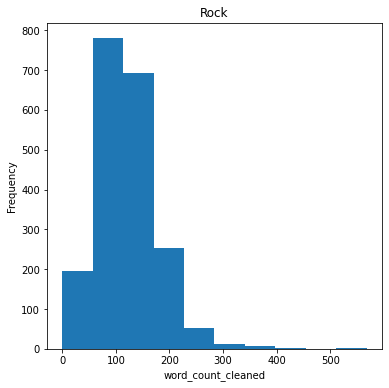

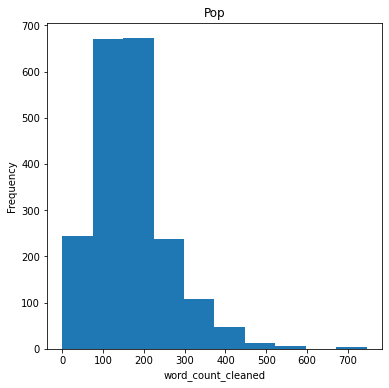

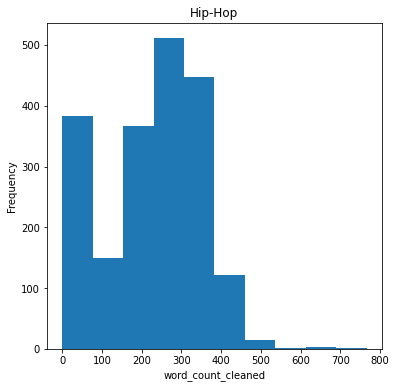

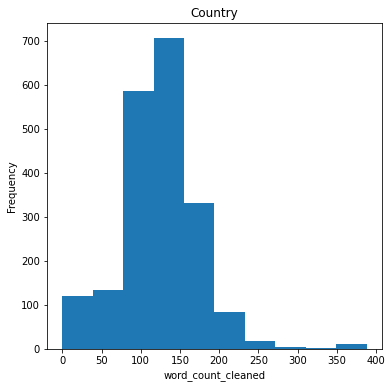

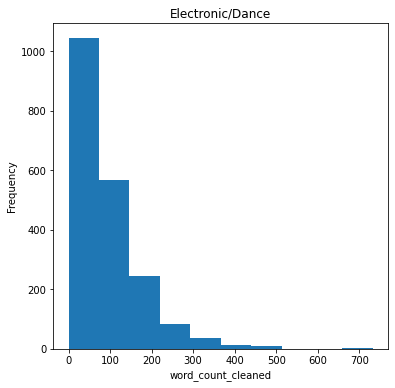

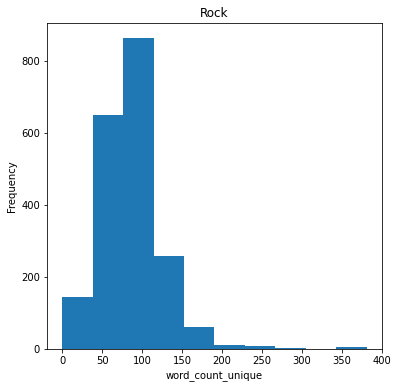

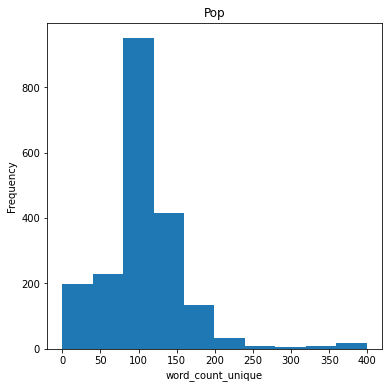

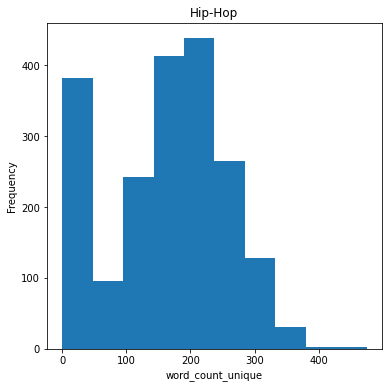

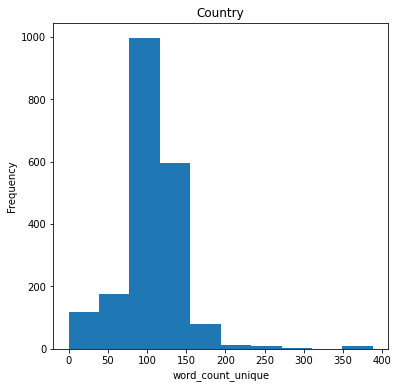

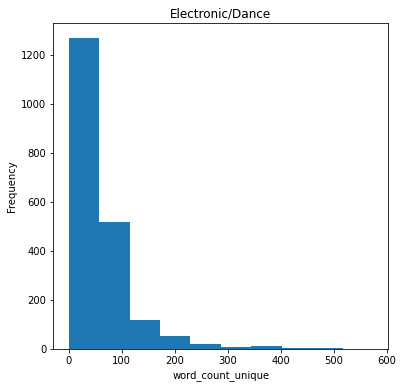

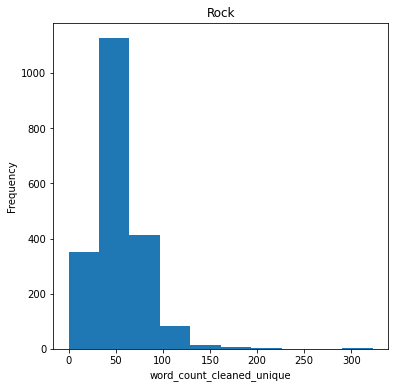

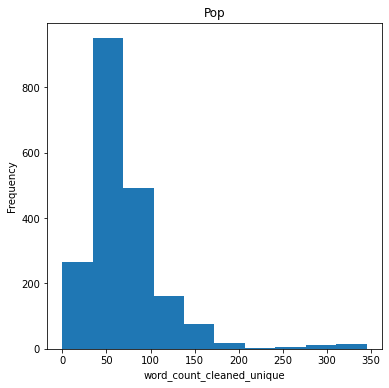

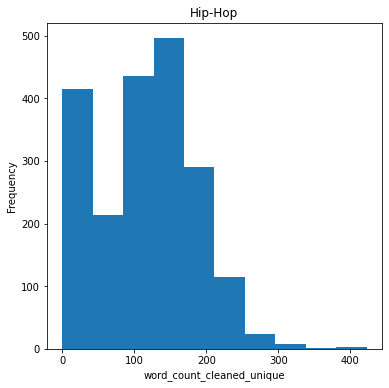

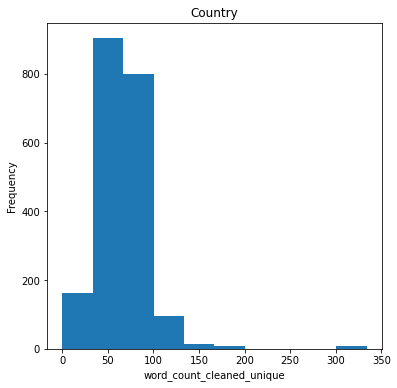

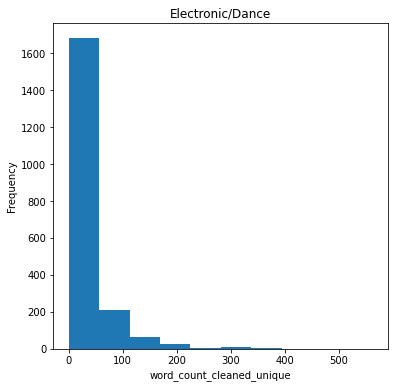

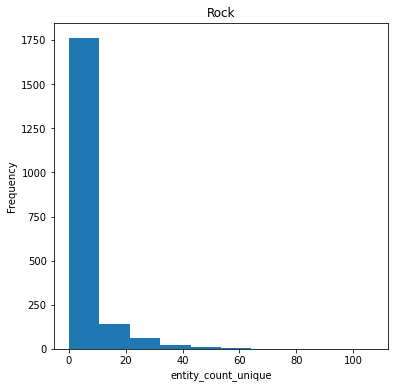

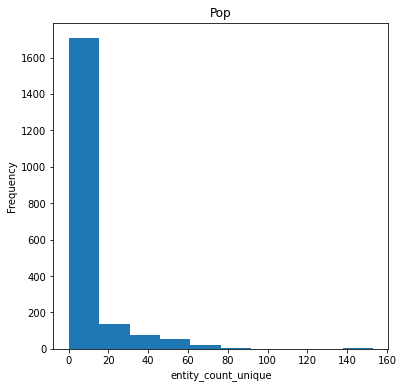

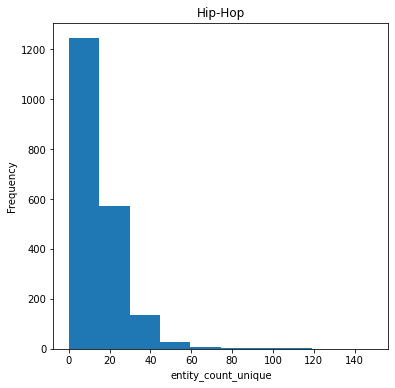

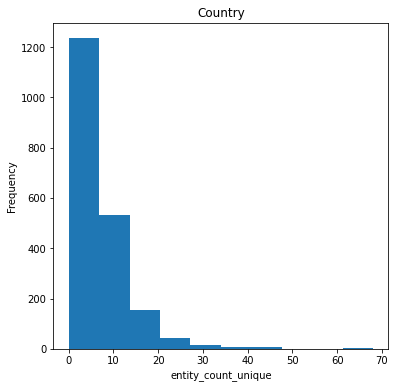

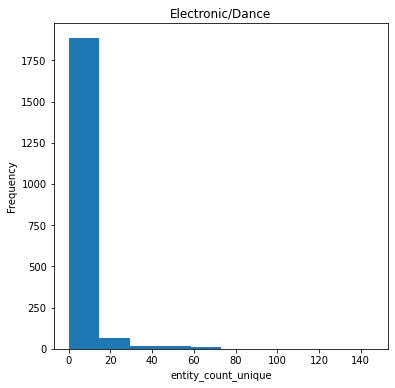

In [31]:
for feature in numerical_variables:
    for genre in genres:
        spotify_df[spotify_df['genre'] == genre][feature].plot.hist()    
        plt.xlabel(feature)
        plt.rcParams['figure.figsize'] = [6, 6]
        plt.title(genre)
        plt.show()   

Upon reviewing the histograms, there is a lot to review and a few insights we can take from them. One takeaway is that the majority of the features seem to have a roughtly normal distribution with a gaussian curve, with a couple being slightly skewed. This indicates for most songs in the dataset, there is a clear mean (the peak of the curve) with an even variance of values both above and below the median. 

There are a few clear exceptions to this - one of these being that all of the features that are a measure of the likelihood of the track being a representative of that feature are all clearly skewed left with the bulk of the songs not being positive. These features include instrumentallness, liveness, and speechiness - all features where the data point measures in a binary sence whether or not a song is fully instrumental, a live recorded track, or spoken word. Besides these, there are a handful of features where there is no clear gaussian curve visible but rather an even mix of points. These are namely valence, tempo, and for some instances word count.

While these histograms were useful in providing some high and low level insights into the distributions of all features across genres in our dataset, having separate graphs makes it more challenging to see clear comparisons between features across genres. As such, we will move on to plot box plots for each feature so we can see the distribution of datapoints, where the middle 50 percent of data lies and any outliers, along with each of the genres on the same graph to compare which genres have the highest group of songs in each category.

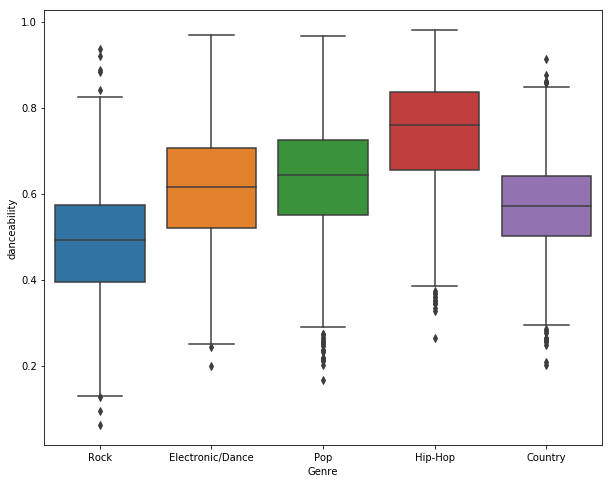

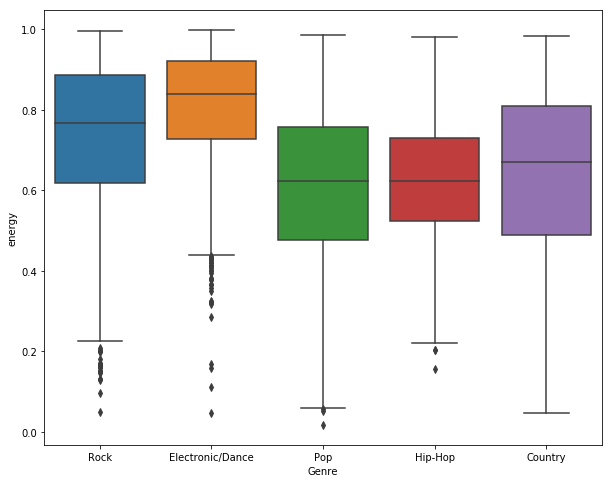

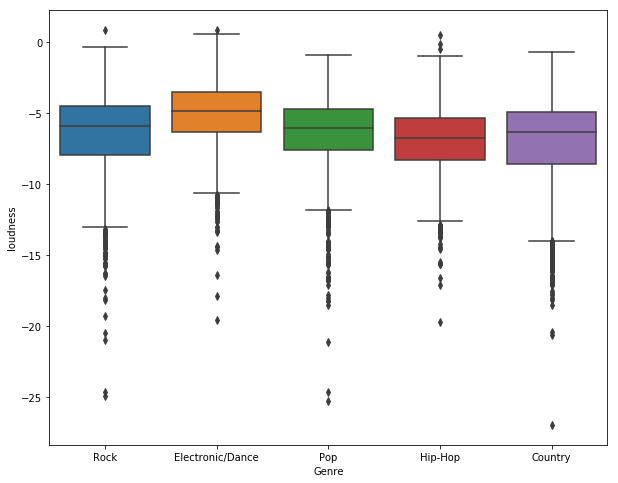

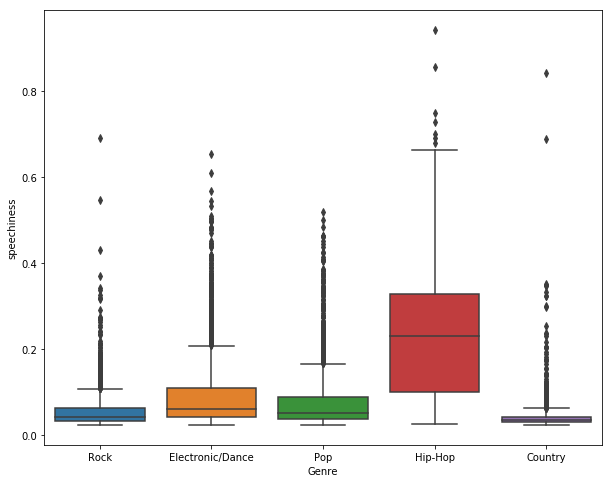

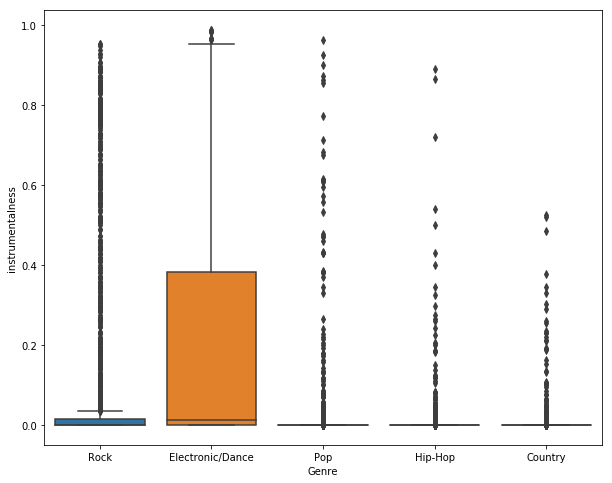

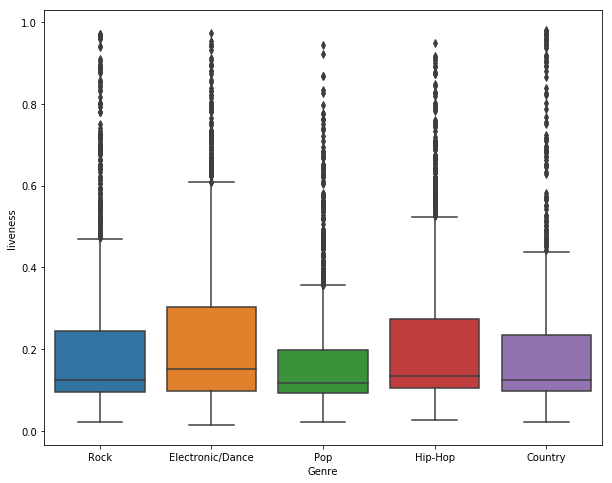

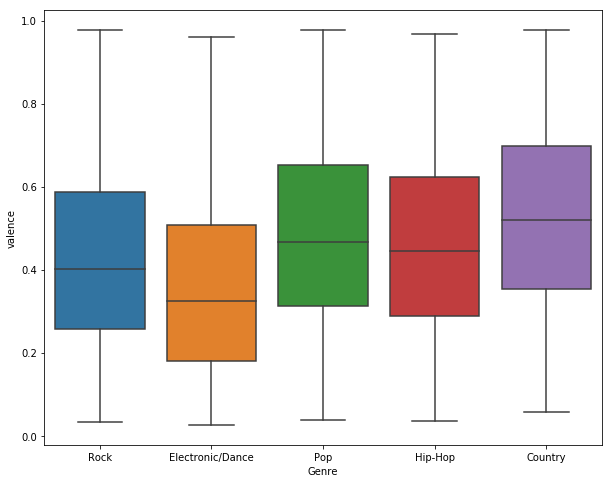

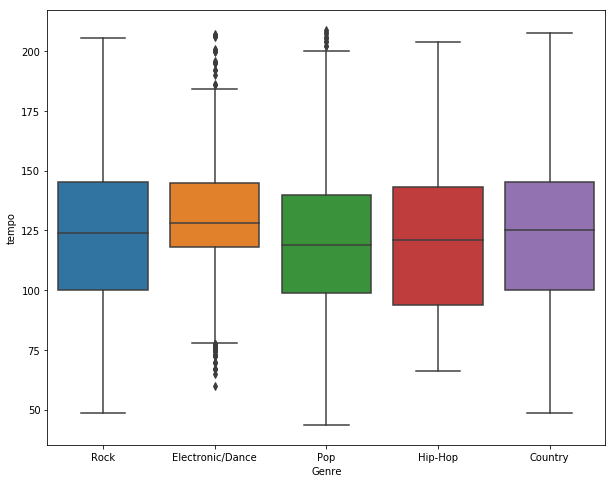

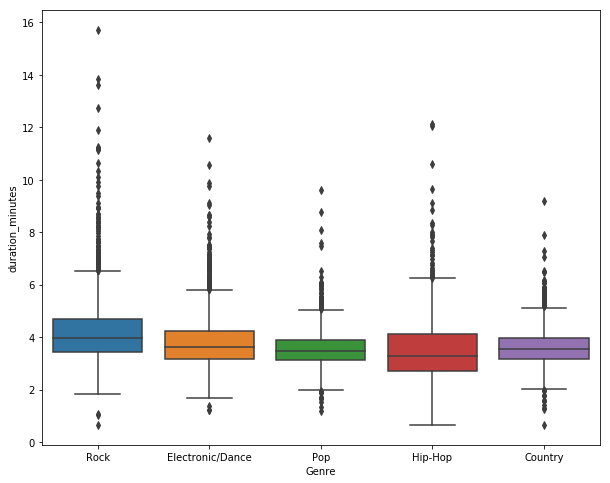

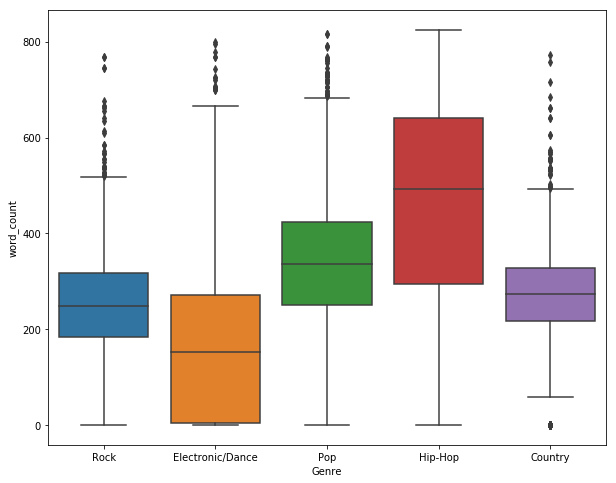

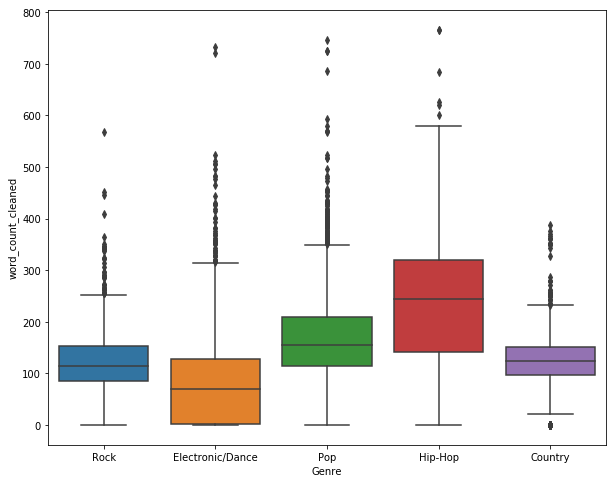

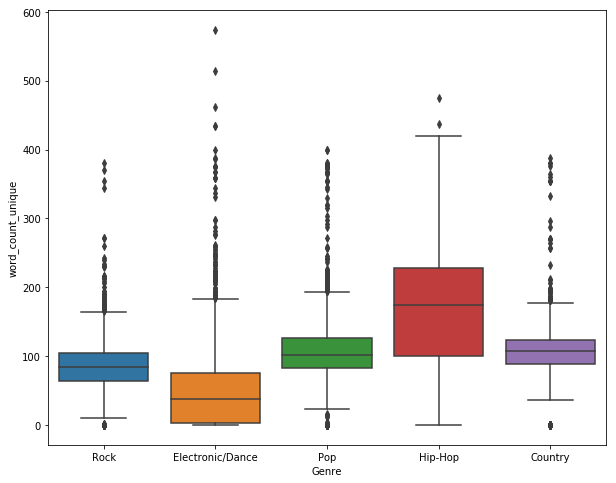

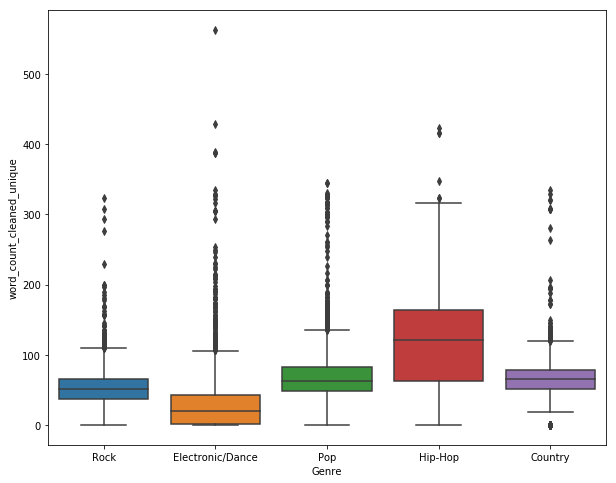

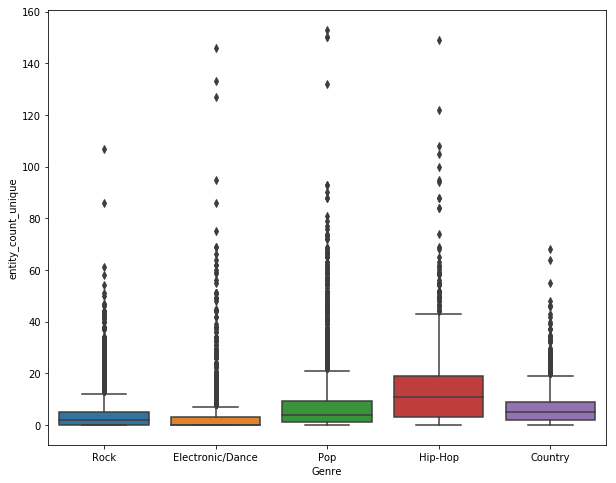

In [73]:
for feature in numerical_variables:
    sns.boxplot(data=spotify_df, x='genre', y=feature)
    plt.xlabel('Genre')
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()    

The box plots of each feature largely reinforce some of the observations that were made from the histograms, such as that the distributions of most of the features are relatively normal given the gaussian curve in the histograms and roughly even shaped box and whiskers for features like danceability, loudness, and word count. Likewise the features that were skewed such as speechless, instrumentalness, and liveness had distinct boxes close to zero and several outliers above which represent the minority of data points where a song was indeed instrumental, a live recording, or contained mostly spoken words. 

The instrumentalness field did interestingly have the box representing the middle 50 percent of data being much higher than the other genres. This is reasonable given the fact that many popular tracks that people would identify as EDM (or within a subgenre of EDM like house or dubstep) often to have fewer to no lyrics. When looking at the word count plots, we can confirm that EDM does have a much lower word count across all tracks the dataset with a median under 200 words.

Similarly, another feature that stands out with a considerably higher distribution of values in a single genre is speechiness, which as previously mentioned is the degree to which spoken word is used in a song. The distribution of all genres is near zero with the exception of Hip-Hop, where the median is above 0.2. This is also makes sense given that most Hip-Hop music involves lyrics that are rapped, or spoken rhythmically but often without a singing pitch, and these lyrics likely register as spoken word. Additionally, we can see that Hip-Hop has by far the greatest median word count, indicative of the genres use of more words in the art of rapping. 

The box plot visualization has provided a much better overview into what features stand out between each genre as you can see with these two examples of particular genres having higher overall medians data points for particular features. These univariate correlations between numerical features can be used once we build our machine learning algorithms to predict genre.

While we have analyzed all of the numerical variables in the histograms and box plots, there are still a few categorical variables we could benefit from exploring. There remains the key and mode as well as the count of track, artist, album and genre and lastly the actual lyrics. We will first tackle visualizing the breakdown of key and mode amongst the songs in each of the 5 genres to see if there are particular values that stand out. To do this, we will plot a simple count plot, which is similar to a histogram but used for discrete categorical variables.

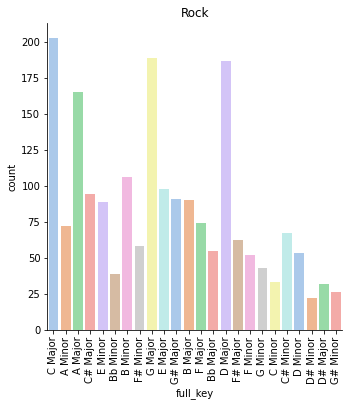

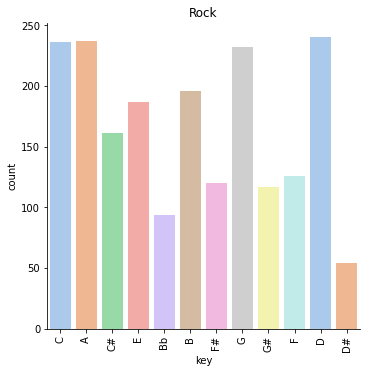

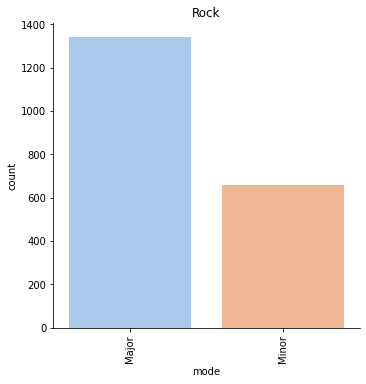

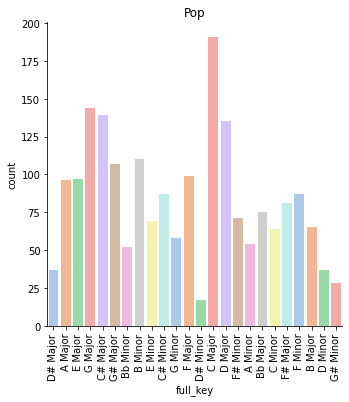

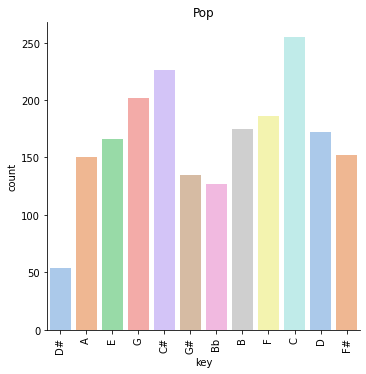

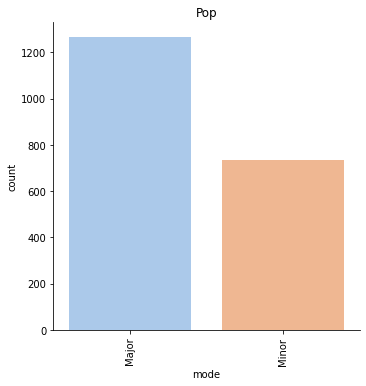

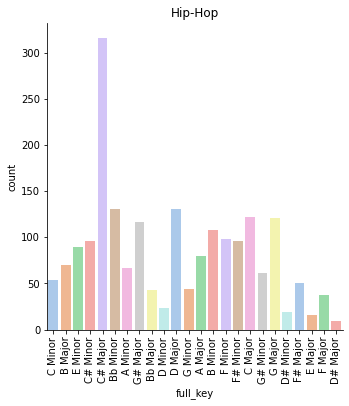

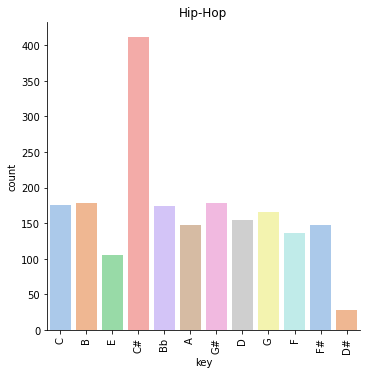

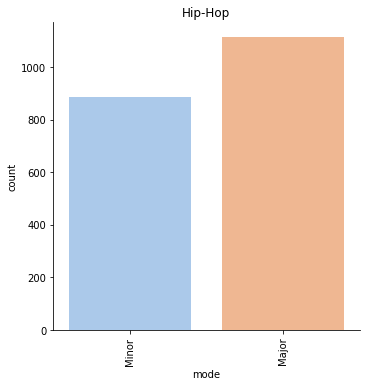

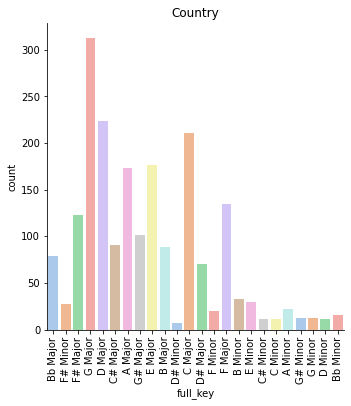

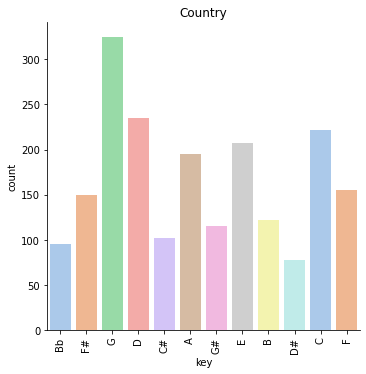

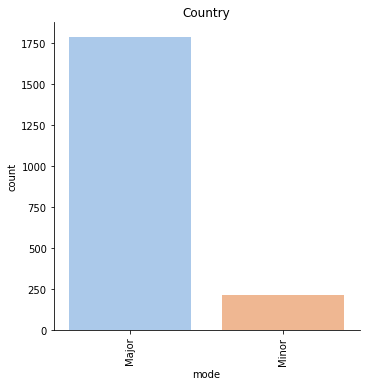

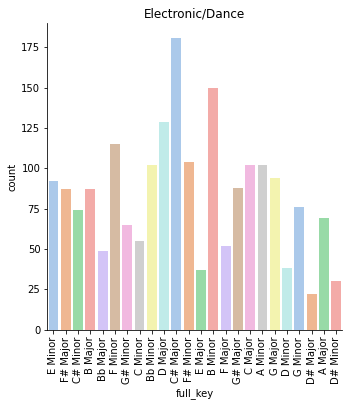

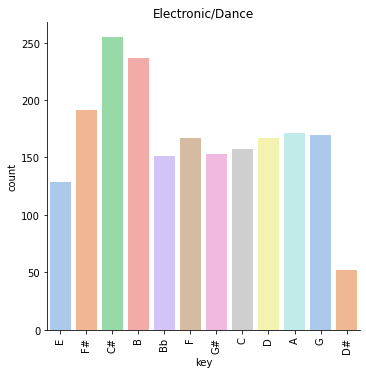

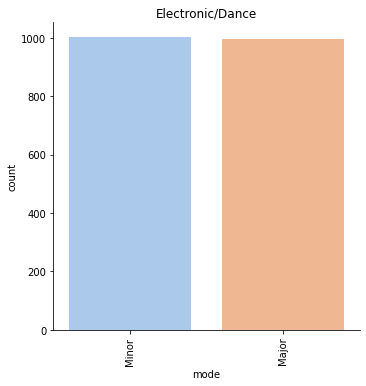

In [22]:
plt.rcParams['figure.figsize'] = [12, 12]

for genre in genres:
    for feature in categorical_variables[1:4]:
        sns.catplot(x=feature, kind="count", palette="pastel", data=spotify_df[spotify_df.genre == genre])
        plt.xticks(rotation=90)
        plt.title(genre)
        plt.show()

Taking a glance at the countplots, there do not seem to be any clear pattern as far as the letter and full key goes given it seems like there is a number of tracks in each key across all genres. The most you could possibly take away from this is the most frequent key in each genre, but it looks like both Rock and Pop as well as Hip-Hop and EDM share the same top key (C major and C# major respectively). The top key in Country looks to be unique in G major, however both Pop and Rock have a high count and the second most of that key. Likewise, the mode does not seem to be particularly unique for any particular genre as it looks to be that the majority of songs in each genre are in Major, with only EDM having a roughly even split. As such, it's unlikely that either the key or mode will be particularly useful in predicting the genre using a model. Nonetheless, it is an interesting exercise to see the distribution as a music enthusiast who spends a lot of time looking into attributes like a songs key when listening.

Another question that arises that's less relevant to genre prediction but important to consider when evaluating the integrity of the dataset with regards to having a diverse enough sample size that's roughly equal across genres is whether the amount of unique tracks, artists, and albums is roughly even across genres. This is because the dataset was selected by using Spotify's front end genre search filters that may potentially have a bias regarding which artists and songs show up in the top search results. For example, I noticed when skimming through the dataset that there were several songs by the same artist and album in the Rock genre. This could potentially be a bias to note considering there are likely to be more similarities in genres where the unique artist or album size is smaller than a genre where there is ideally only one song per artist. As such, we will use the count of unique values column that was added to the dataframe in the previous notebook to plot pie charts of the distribution of tracks, artists, and albums. 

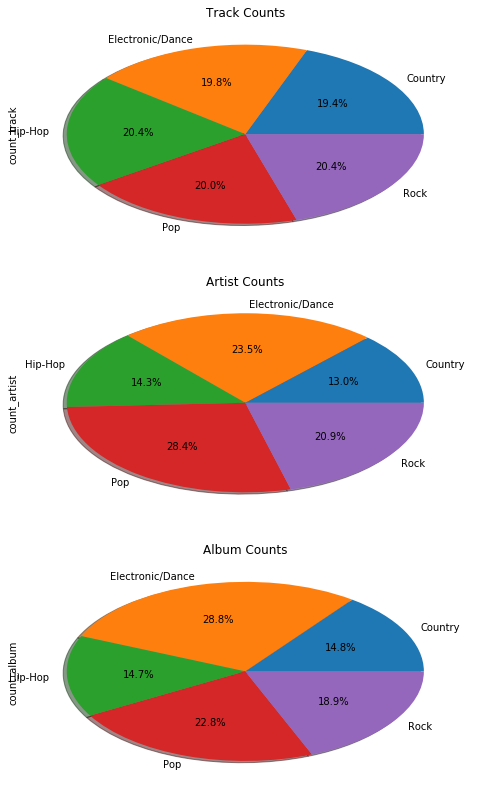

In [109]:
#Plot pie charts of count track, artist, album across genres
fig, axes = plt.subplots(nrows=3, ncols=1)
#fig.delaxes(axes[3,1])

spotify_df_agg.plot(ax=axes[0], kind='pie', y='count_track', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['genre'], title='Track Counts', legend=False, shadow=True, )

spotify_df_agg.plot(ax=axes[1], kind='pie', y='count_artist', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['genre'], title='Artist Counts', legend=False, shadow=True)

spotify_df_agg.plot(ax=axes[2], kind='pie', y='count_album', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['genre'], title='Album Counts', legend=False, shadow=True)

plt.show()

After plotting the pie charts, we can see that as far as the number of unique tracks are concerned, there is about as even of a split as possible with around 20% each, which is what we hoped for. However, when looking at artists and albums there does appear to be a smaller sample of unique artists in Hip-Hop and Country. This indicates that there are a lot of songs by the same artist in those two genres. While this is not the ideal breakdown of songs per artist, it is fortunately not skewed too heavily towards any genre. We will note this down as a potential bias in the dataset that could potentially be improved on, but in reality no dataset is perfect and this method got us fairly close.

The next thing we will want to explore after completing some EDA is to take a look at some of the statistical metrics between the feature and target variables. Given that our target variable of genre is categorical, we cannot compute a traditional pearson correlation between the variables and the target. There are statistical metrics that measure the relationship between numerical variables and dichotomous targets, but given that we are working with 5 genres, those do not apply either. As such, one thing we can still explore is to generate a covariance matrix to see whether any of the feature variables may be highly correlated to one another, which could assist in feature selection. 

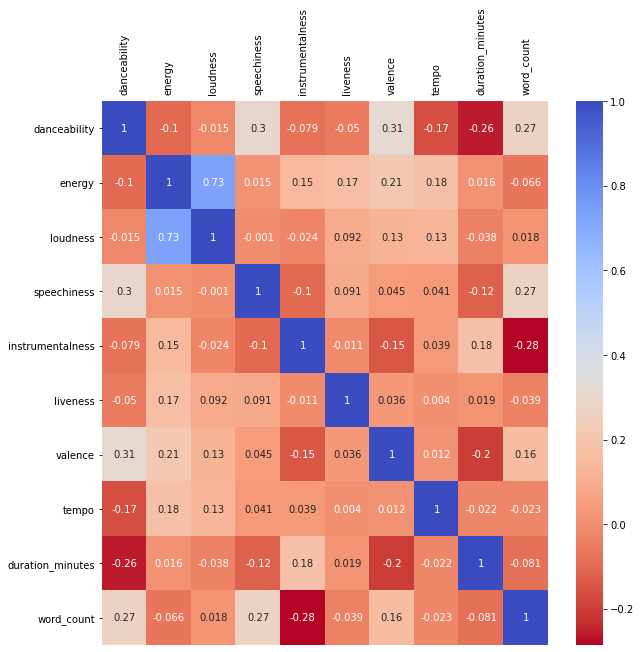

In [16]:
#Correlation Matrix including Y-variables (rates) 
corr = spotify_df[numerical_variables[:10]].corr().round(3)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(corr, annot=True, cmap='coolwarm_r')
plt.tick_params(labeltop=True, labelbottom=False, bottom=False)
plt.xticks(rotation=90)
plt.show()

Taking a look at our covariance matrix, it appears that there is very low correlation between almost all of the variables in our dataset. A pearson correlation with an absolute value of over .50 is generally the threshold for whether two variables are dependent. Given that all variables but loudness and energy have values lower than that, we can reasonably assume they are independent, which is an important requirement for machine learning algorithms such as regression. Energy and loudness do appear to be highly correlated with one another, so depending on the modeling we use we could consider whether to include one or both.

Moving forward, there still remains the lyrical data in our datafram that is yet to be explored. We spent extensive time wrangling the text data and taking pre-processing steps such as removing stop words and lemmatizing which leaves us with a much cleaner dataset to work with. While we were able to generate a numerical metric using the lyrical data when we computed the word count by counting the total word tokens in our lyrics column, we can still gain additional predictive potential by actually analyzing the content of the lyrics itself. One of questions that arises is to determine what type of words and topics are most frequent in the lyrics across each genre, and if there are any commonalities between the lyrics of each song within a genre that can be used to predict genre. We can explore that aspect further in the next sectin when applying ML models such as Naive Bayes alongside a feature extraction technique such as Count Vectorizer or TFIDF. 

However, there is some relatively straightforward EDA we could do prior in order to get an idea of the most frequent words across the dataset. One powerful and neat package we can use is WordCloud, which generates a visual summary of the words in a piece of text with the most frequent words appearing in the center and the largest. We will generate a separate cloud for each genre below by using the cleaned lyrics column we developed in the pre-processing steps.

In [225]:
','.join(list((spotify_df[(~spotify_df['lyrics'].isnull()) & (spotify_df['genre'] \
                                                        == 'Rock')]['lyrics'].head(1).values)))

"   gettin' born in the state of mississippi poppa was a copper and her momma was a hippie in alabama she would swing a hammer price you gotta pay when you break the panorama she never knew that there was anything more than poor what in the world what does your company take me for black bandana sweet louisiana robbin' on a bank in the state of indiana she's a runner rebel and a stunner on her merry way sayin' baby what you gonna— lookin' down the barrel of a hot metal 45 just another way to survive   california rest in peace simultaneous release california show your teeth she's my priestess i'm your priest yeah yeah   she's a lover baby and a fighter shoulda seen her comin' when it got a little brighter with a name like dani california day was gonna come when i was gonna mourn ya a little loaded she was stealin' another breath i love my baby to death   california rest in peace simultaneous release california show your teeth she's my priestess i'm your priest yeah yeah   who knew the ot

In [3]:
# Join all the lyrics in each genre together
rock_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['genre'] \
                                                                            == 'Rock')]['lyrics_cleaned_str'].values)))
country_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['genre'] \
                                                                            == 'Country')]['lyrics_cleaned_str'].values)))
pop_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['genre'] \
                                                                            == 'Pop')]['lyrics_cleaned_str'].values)))
hiphop_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['genre'] \
                                                                            == 'Hip-Hop')]['lyrics_cleaned_str'].values)))
edm_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['genre'] \
                                                                            == 'Electronic/Dance')]['lyrics_cleaned_str'].values)))

genre_clouds = [rock_cloud, country_cloud, pop_cloud, hiphop_cloud, edm_cloud]

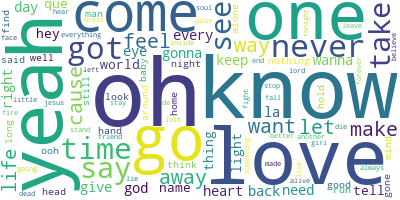

In [6]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue', collocations=False)

# Generate a word cloud
wordcloud.generate(rock_cloud)

# Visualize the word cloud
wordcloud.to_image()

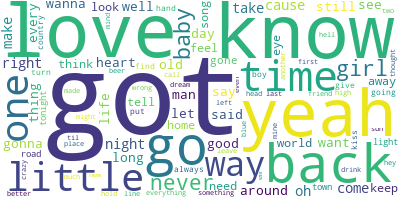

In [7]:
# Generate and visualize the word cloud for Country music
wordcloud.generate(country_cloud)

wordcloud.to_image()

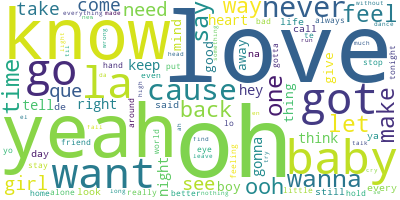

In [9]:
# Generate and visualize the word cloud for Pop music
wordcloud.generate(pop_cloud)
wordcloud.to_image()

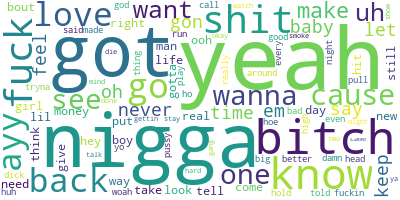

In [10]:
# Generate and visualize the word cloud for Hip-Hop music
wordcloud.generate(hiphop_cloud)
wordcloud.to_image()

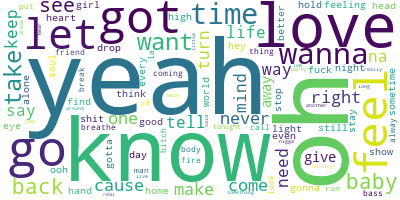

In [11]:
# Generate and visualize the word cloud for EDM music
wordcloud.generate(edm_cloud)
wordcloud.to_image()

The clouds above present a unique visual and quick look into some of the most frequent words and phrases that pop out across the lyrics in each genre. This helps us to get an idea about what some of the potential topics of discussion are across all the songs in a particular genre. Taking a look at the clouds, there are a lot fo filler words such as "oh" and "yeah" present across all genres, which is to be expected given that these are frequently used in a musical sense in order to sing a note of riff along without being too difficult to say they are short one-syllable words that contain a single vowel that can be stretched. These unfortunately do not provide much predictive insight, but other words inside the clouds can be seen that do. Both the Pop and Country word cloud for example seem to emphasize the word "love", potentially implying a high frequency of love songs which are a common theme across all types of music. Even more revealing is the Hip-Hop cloud which emphasizes several words considered profanity, which is something that is expected to be characteristic of rap lyrics as well. 

While these clouds help provide a quick high level view of a particular text, it is difficult to determine the exact frequency of words since it is only implied by size. As such, a better way to disect the most frequent words in a text would be to use a word tokenizer and counter such as Count Vectorizer or TFIDF to fit to our data and plotting the top words by frequency according to them. We will do this below by using a custom function and applying it to each genre while testing both vectorizers.

In [4]:
# Custom function that takes word vectorizer and plots the top 10 most frequent words in the specified dataset
def plot_10_most_common_words(count_data, vectorizer, title_name):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 10/1.6180))
    plt.subplot(title=title_name)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer and tfidg vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

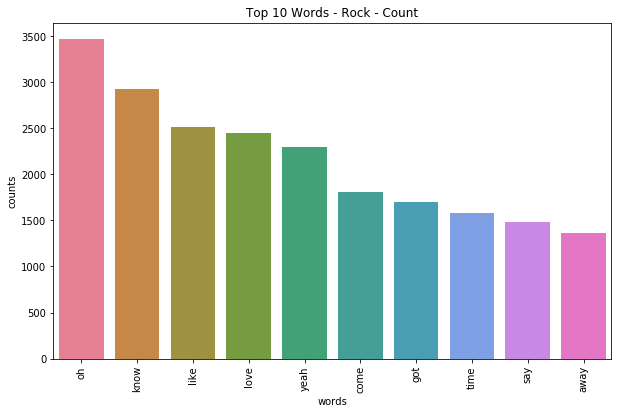

In [7]:
# Fit and transform the processed titles
count_rock = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Rock')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_rock, count_vectorizer, 'Top 10 Words - Rock - Count')

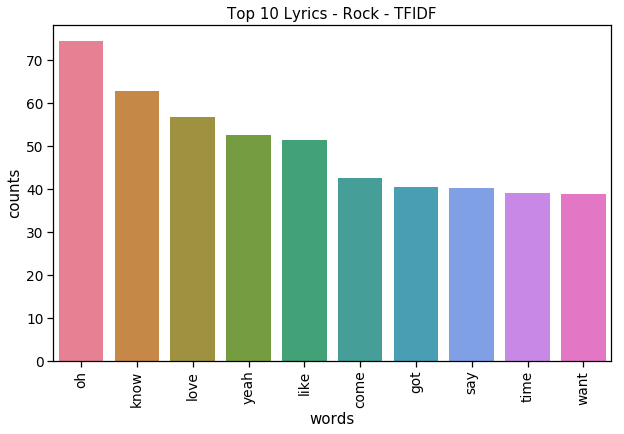

In [8]:
# Fit and transform the processed titles
tfidf_rock = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Rock')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_rock, tfidf_vectorizer, 'Top 10 Lyrics - Rock - TFIDF')

The above plots display the top 10 words for all the data in the Rock genre for both using both Count Vectorizer and TFIDF. The difference between these two vectorizers is that the Count Vectorizer simply counts the frequency of words in a document straight up, while the TFIDF, or term frequency inverse document frequency, accounts for words that occur frequently throughout a document by weighting them lower so as to highlight unique words rather than filler words. In this case it looks like some of the most frequent words remained consistent throughout both counters, but there were a few words boosted.

The words displayed in both do seem to be all fairly common words such as the filler lyrics in "oh" and "yeah" as well as words used in average sentences such as "know", "like", and "come". Let's plot the two vectorizers similarly for the rest of the genres and see if there's anything further that standas out.

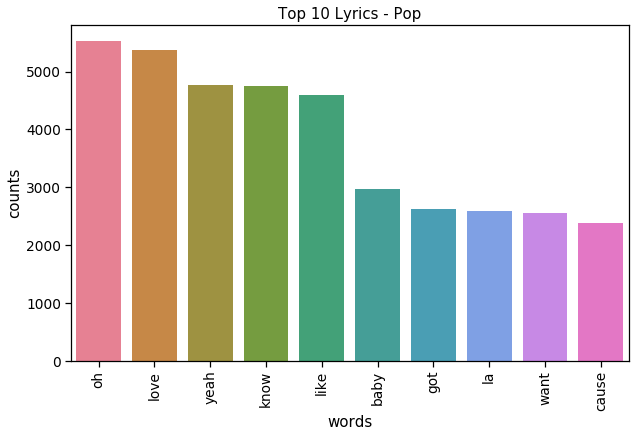

In [9]:
# Fit and transform the processed titles
count_pop = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Pop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_pop, count_vectorizer, 'Top 10 Lyrics - Pop')

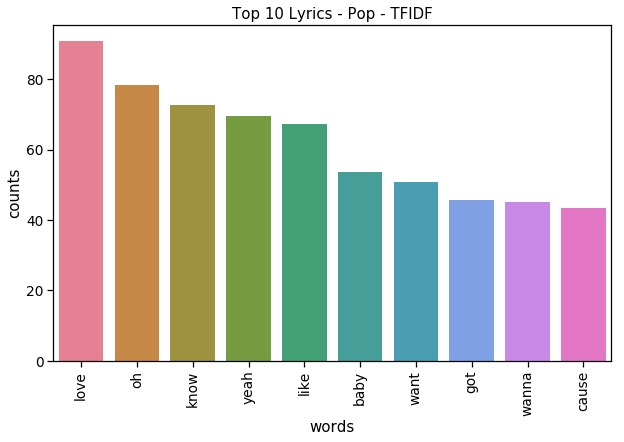

In [10]:
# Fit and transform the processed titles
tfidf_pop = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Pop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_pop, tfidf_vectorizer, 'Top 10 Lyrics - Pop - TFIDF')

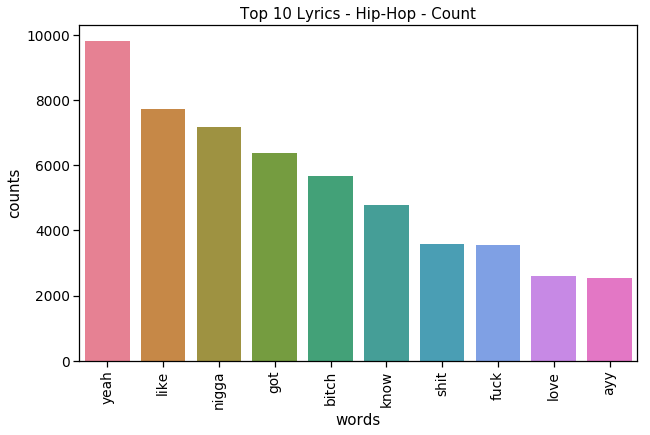

In [11]:
# Fit and transform the processed titles
count_hiphop = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Hip-Hop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_hiphop, count_vectorizer, 'Top 10 Lyrics - Hip-Hop - Count')

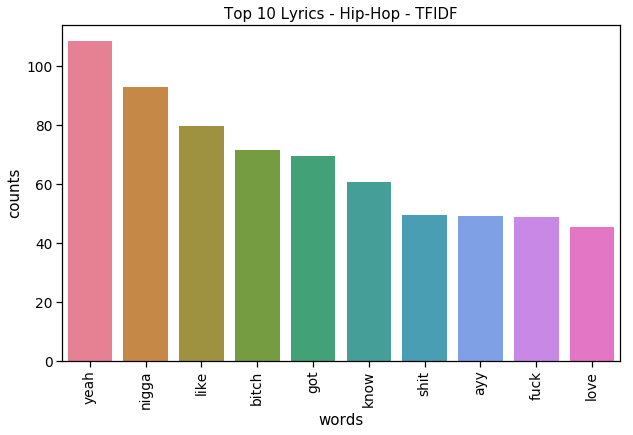

In [12]:
# Fit and transform the processed titles
tfidf_hiphop = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Hip-Hop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_hiphop, tfidf_vectorizer, 'Top 10 Lyrics - Hip-Hop - TFIDF')

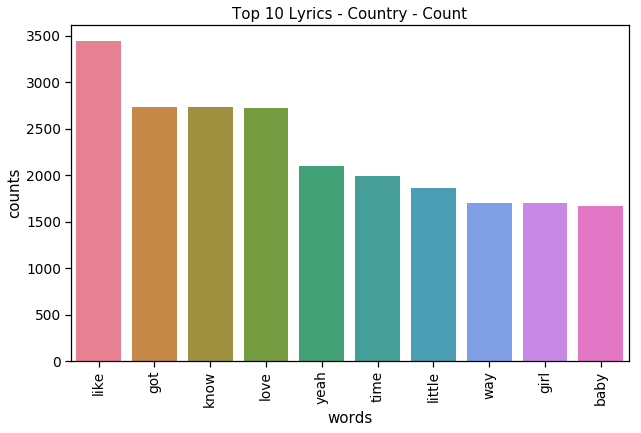

In [13]:
# Fit and transform the processed titles
count_country = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Country')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_country, count_vectorizer, 'Top 10 Lyrics - Country - Count')

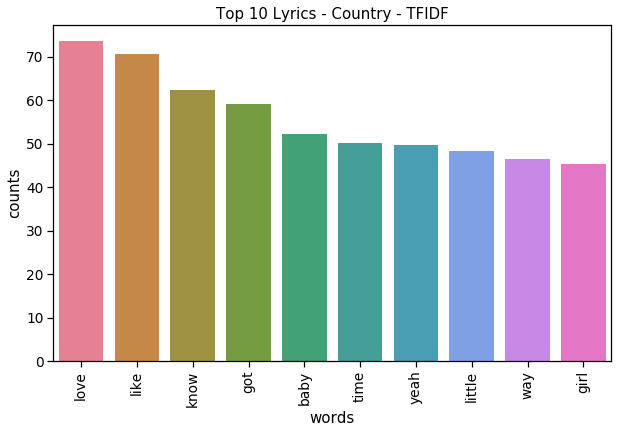

In [14]:
tfidf_country = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Country')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_country, tfidf_vectorizer, 'Top 10 Lyrics - Country - TFIDF')

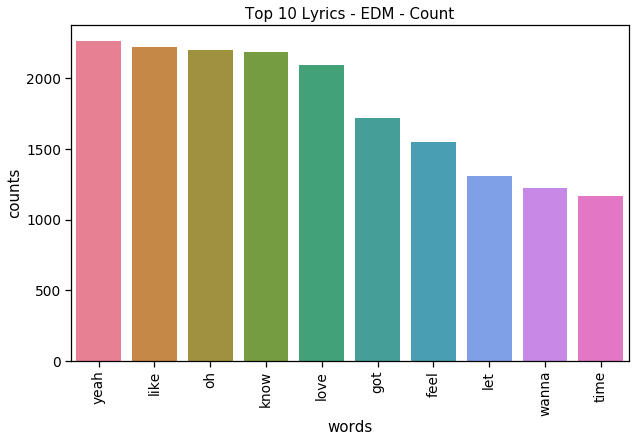

In [15]:
# Fit and transform the processed titles
count_edm = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Electronic/Dance')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_edm, count_vectorizer, 'Top 10 Lyrics - EDM - Count')

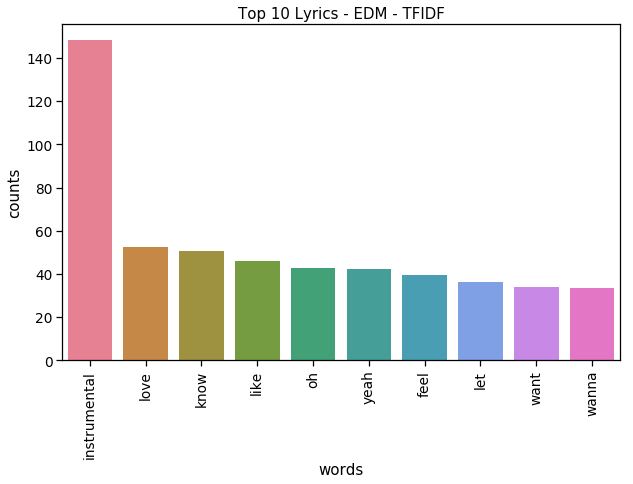

In [16]:
tfidf_edm = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Electronic/Dance')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_edm, tfidf_vectorizer, 'Top 10 Lyrics - EDM - TFIDF')

Taking a look at the count plots for the remaining genres, it looks like EDM, Country, and Pop all have a lot of common top words with one another along with the previously reviewed words for Rock. The words "oh", "like", "know", and "yeah" seem to appear consistently across all 5 genres. A few words that stand out a little more in fewer genres are "love" and "baby". Overall it's difficult to pick up and clearly unique words across most of the genres when looking at the counts. The only genre where the words stand out significantly is Hip-Hop, where the majority of the top 10 words include profanity ("nigga", "bitch", "shit", "fuck"). The inclusion of these words in lyrics may potentially be the most identifiable feature that at the very least can be used to determine whether or not a particular song is or is not classified as Hip-Hop.

These word clouds and count plots provided a fairly easy high level overview of what is contained in the lyrics across all the genres. We will now use more advanced analysis of unsupervised modeling using LDA (Latent Dirichlet Allocation) to parse through the lyrics across all musical genres as well as each genre individually to see if we can discover any specific topics or subjects that separate each genre or even may help us identify subgenres.

In [17]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Custom function to use LDA to search for potential topics within text input
def print_topics(model, vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [63]:
# Create and fit the LDA model
count_total = count_vectorizer.fit_transform(spotify_df[~spotify_df['lyrics_cleaned_str'].isnull()].lyrics_cleaned_str)
count_vectorizer.fit_transform(spotify_df[~spotify_df['lyrics_cleaned_str'].isnull()].lyrics_cleaned_str)
lda_total = LDA(n_components=10)
lda_total.fit(count_total)


# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_total, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
like yeah know got bitch girl want time say right

Topic #1:
la lord song sing light jesus gimme soul city holy

Topic #2:
ooh yeah uh na baby ah turn nah woo gang

Topic #3:
god come shake stand save fight ready power breathe life

Topic #4:
feat boom drip dem lil beep gucci mr rose sauce

Topic #5:
love oh know feel let way like heart away cause

Topic #6:
yeah hey sunday oh hoo blah rhythm ey wa baar

Topic #7:
gon yo da body yuh wet water trick walk doh

Topic #8:
nigga fuck shit got like ayy money em hit lil

Topic #9:
que la te el en yo mi lo se tu


The first topic model generated was across the entire dataset with a breakdown of 10 topics with up to 10 words each. Taking a quick glance at each topic, there appear to be a few topics where a clear commonality and potential central subject can be implied while other are hard to interpret. Topic #2 seems to be pretty clearly representative of Christian themed music given the frequency of words like "light", "jesus", "soul", and "holy". It does appear that topic #4 is similarly religious themed with the use of words "god", "breathe", and "life". It is difficult to determine why these two topics were separated using this analysis alone, but we can reason that perhaps topic #2 is more specifically Christian themed whereas topic #4 is more broadly religious or spiritual themed lyrics rather than specifying any exclusively Christian themes. It is likely that if visualized, these two topics would be in a similar cluster, and if we instatiated the LDA model with fewer components they may perhaps be combined. 

Beyond the religious themed topics, we can see that topic #8 and #2 look to be thematically rap based with the profanity highlighted ("nigga", "fuck", "shit") while also including words like "money" nad "hit" as well as "bitch" and "girl" in topic #0. One of the commonly implied stereotypes in the genre of Hip-Hop is that much of the lyrics rapped involve the trope of largely involving "drugs, sex, and money" and these keywords in the topic model reinforce that this may indeed be representative of a portion of our dataset.

Beyond the religious and rap themes, the remaining are difficult to interpret. As such, given this hypothesis that fewer topics will help combine some of the clusters and bring about more identifiable topics, we will re-run the model with only 5 components to see if the potential overlap between our 10 with topics 9 and 0 as well as 4 and 2 is accounted for. This may help us discern more clear topics given half of our 10 are difficult to interpret.

In [18]:
# Create and fit the LDA model
count_total = count_vectorizer.fit_transform(spotify_df[~spotify_df['lyrics_cleaned_str'].isnull()].lyrics_cleaned_str)
lda_total = LDA(n_components=5)
lda_total.fit(count_total)


# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_total, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
oh god come life let heart light lord world soul

Topic #1:
na yeah hey bomb dum drop halo wub не blah

Topic #2:
yeah nigga bitch like got fuck shit ayy uh gon

Topic #3:
know love like yeah got time baby cause want wanna

Topic #4:
la que da te el en yo mi lo se


After running the model with only 5 topics, there appear to be a lot more apparent themes. As mentioned in the previous run, it looks like there is only a single religious topic that encompasses Christian as well as spiritual themes in topic #0. Along with this, there appears to be one Hip-Hop inspired theme in topic #2. Of the other 3 topics, topics #3 and #4 are somewhat interpretable while #1 is difficult to discern. Topic #3 appears to revolve around love with words "love", "baby", and "wanna" and so may represent love songs across all genres and possibly more specifically Country and Pop. Topic #4 is quite clearly an assortment of Spanish words that were surprisingly detectable even though the models we used are primarily based on the English language. With this, we have gained a lot of insight into potential themes can see a lot of potential for further exploration when toying around with the models further and potentially applying visualization tools to see the clusters. This will be explored and touched on in the next steps to this project. For now, we will apply the LDA to each individual genre dataset and see if we can find any potential subgenres.

In [19]:
# Create and fit the LDA model
lda_rock = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Rock')].lyrics_cleaned_str))
lda_rock.fit(count_rock)


# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_rock, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
yeah oh like got know gonna time wanna feel make

Topic #1:
love oh know say way feel like need away time

Topic #2:
la que te el mi en tu nah ah yo

Topic #3:
god heart come let jesus love lord life holy oh

Topic #4:
na ich 限りなく黒に近いグレイ ああ pa du 聖者たち feat きみが欲しいのさ まだ空っぽな明日は


In [20]:
# Create and fit the LDA model
lda_pop = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Pop')].lyrics_cleaned_str))
lda_pop.fit(count_pop)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_pop, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
yeah oh ich love na du sie baby need 내가

Topic #1:
love oh know like yeah baby got want cause wanna

Topic #2:
la que te en el qué na mi yo se

Topic #3:
da ba feat dee dye blue bum halo lil ayy

Topic #4:
come shake ah girl bitch oh doh hey pop jesus


In [21]:
# Create and fit the LDA model
lda_hiphop = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Hip-Hop')].lyrics_cleaned_str))
lda_hiphop.fit(count_hiphop)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_hiphop, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
la movin que el ey bam mi forward tú en

Topic #1:
woah na feat loner woop king lil black da la

Topic #2:
la не bir меня на что мне ты da как

Topic #3:
like know got nigga yeah love shit cause fuck time

Topic #4:
yeah bitch nigga like got ayy fuck shit uh ooh


In [22]:
# Create and fit the LDA model
lda_country = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Country')].lyrics_cleaned_str))
lda_country.fit(count_country)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_country, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
country got yeah song little girl boy like said come

Topic #1:
love know like got baby time way yeah girl make

Topic #2:
feat drinkin chain smokin quit el choo lost famous la

Topic #3:
got little old big town cowboy like na texas man

Topic #4:
like night blue yeah time la going oh old got


In [23]:
# Create and fit the LDA model
lda_edm = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['genre']  == 'Electronic/Dance')].lyrics_cleaned_str))
lda_edm.fit(count_edm)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_edm, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
la bass breathe boom beep dun hum nyu blah cannon

Topic #1:
yeah drop dem city light man run away ha dum

Topic #2:
got love like want turn fuck come hey know let

Topic #3:
na low feat untz wub instrumental dub baar push song

Topic #4:
oh know feel like wanna time baby right let love


Taking a look at the genres LDA breakdown, we can see some interesting subtopics within the genres. For Rock, it looks like there is a Spanish language topic, which may potentially represent Spanish rock, as well as a religious component, potentially representing Christian rock. Along with this we can see some additional foreign language character that seems to be an Asian language, as well as the common love based themes. In Pop, we can see some more Spanish language topics as well as profanity, which potentially suggests some sort of an overlap between Pop and Rap music. In Country, we can see some clear "out in the country" lyrical themes in topic #3 beyond the love themes.

Using LDA has proved to be a powerful tool for breaking down text data and it has been fascinating to apply it to explore the lyrics across our dataset. We will now continue on to the next section to apply ML techiques to build a predictive model that uses lyrics as well as the Spotify musical attributes to predict the genres of individual songs.